In [1]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

## Ajout du chemin source
import os
import sys
NumAppPath = os.path.abspath('../../NumApp')
sys.path.append(NumAppPath)

dataPath = os.path.join(NumAppPath,"dataTest")


## Paramètres 
plt.rcParams["figure.figsize"] = (15,10)


# Etude test 

## Matrice de Distance
Le premier algorithme qui compare les points d'intérêts extrait par processus gaussiens permet d'obtenir une matrice des "Distance" entre chaque pièce

In [2]:
from ImageProcessing.processing import cropToCoin
import plotly.express as px

def transformDist(D:np.ndarray)->np.ndarray:
    D = np.nan_to_num(D)
    D = D + D.T
    np.fill_diagonal(D,np.min(D))
    D = D + np.abs(np.min(D))
    return D
    

In [3]:
dataList = sorted(os.listdir(dataPath))
#print(dataList)
#img = cropToCoin(os.path.join(dataPath,dataList[197]))
#plt.imshow(img)


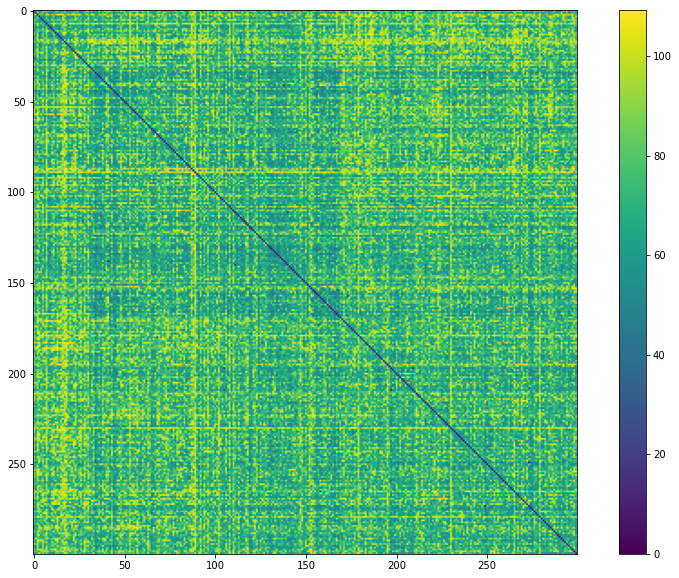

In [52]:
DRaw = np.load("DistMatrix19.npy")
D = transformDist(DRaw)
plt.imshow(D)
plt.colorbar()
plt.show()

(array([4.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 8.000e+00,
        3.200e+01, 2.810e+02, 1.191e+03, 3.044e+03, 4.603e+03, 5.559e+03,
        6.020e+03, 5.555e+03, 4.227e+03, 3.242e+03, 2.714e+03, 2.677e+03,
        3.396e+03, 2.284e+03]),
 array([-114.27115717, -108.81181422, -103.35247127,  -97.89312832,
         -92.43378537,  -86.97444241,  -81.51509946,  -76.05575651,
         -70.59641356,  -65.13707061,  -59.67772766,  -54.21838471,
         -48.75904176,  -43.29969881,  -37.84035585,  -32.3810129 ,
         -26.92166995,  -21.462327  ,  -16.00298405,  -10.5436411 ,
          -5.08429815]),
 <BarContainer object of 20 artists>)

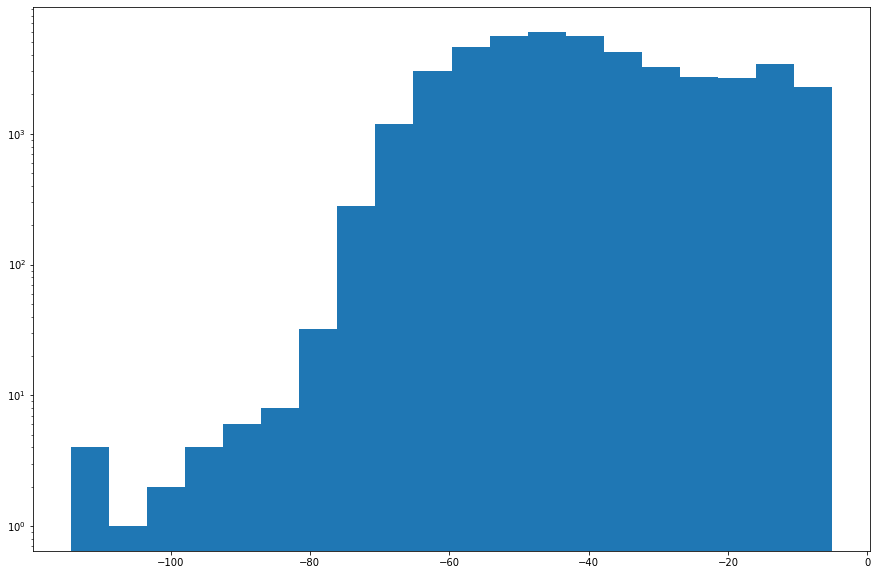

In [53]:
Dhist = DRaw.ravel()
Dhist = Dhist[~np.isnan(Dhist)]
plt.hist(Dhist,20,log=True)


Une valeur de distance faible correspond à des monnaies qui se ressemblent

## Représentation des valeurs 
Algorithme T-SNE (t-distributed stochastic neighbor embedding)


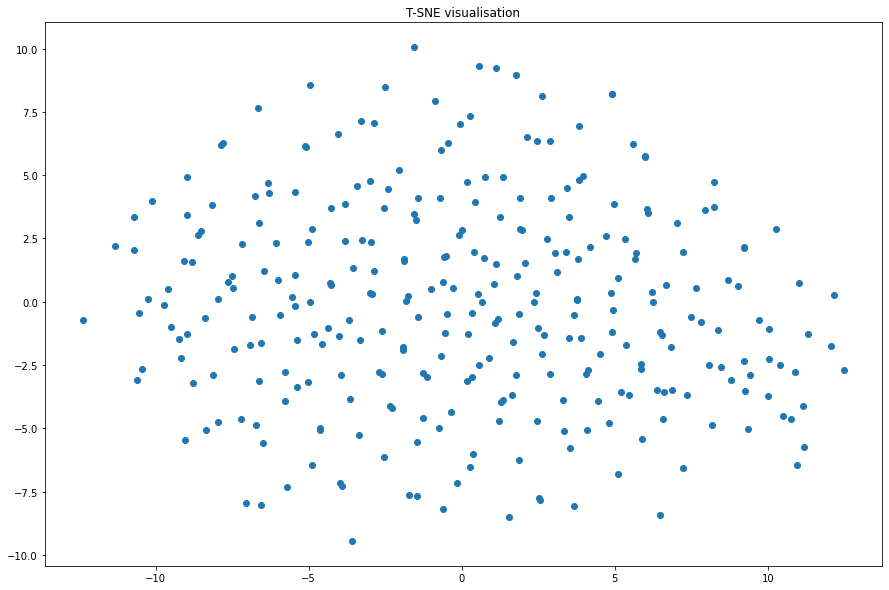

In [54]:
from sklearn.manifold import TSNE


X = TSNE(n_components=2, learning_rate='auto',metric='precomputed', init='random',square_distances=True).fit_transform(D)

plt.scatter(X[:,0],X[:,1])
plt.title("T-SNE visualisation")
plt.show()

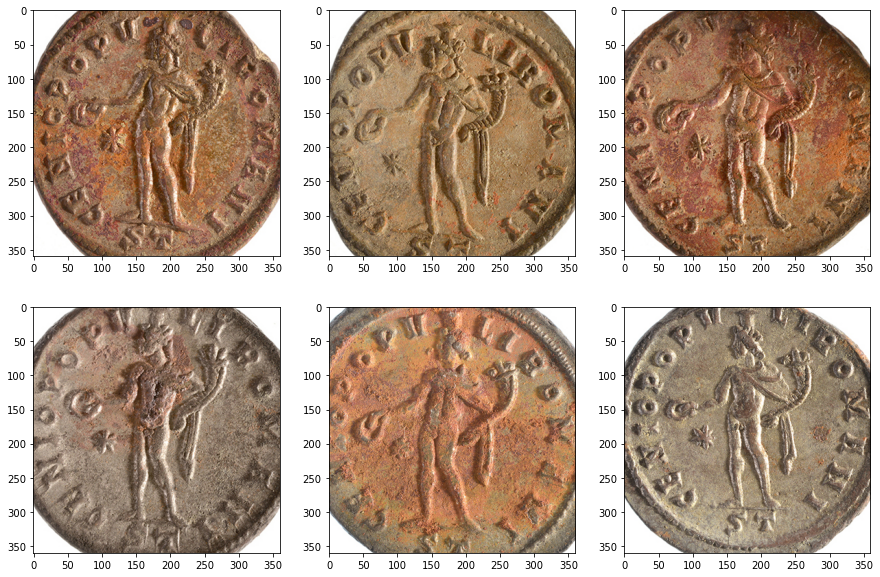

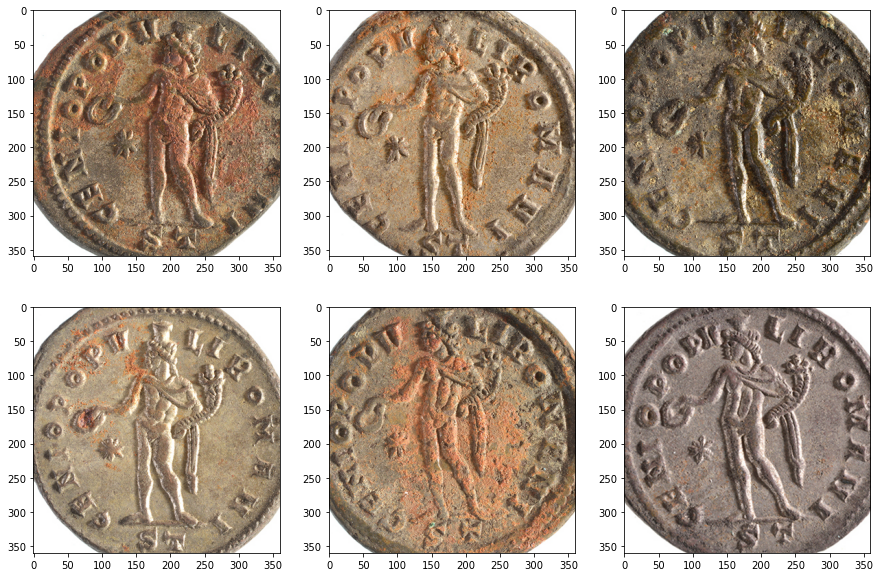

<Figure size 1080x720 with 0 Axes>

In [33]:
idOut = np.argwhere(X[:,1]>2).ravel()
place = 0 
for id in idOut:
    place = place +1
    plt.subplot(2,3,place)
    img = cropToCoin(os.path.join(dataPath,dataList[id]))
    plt.imshow(img)
    if place == 6:
        place = 0
        plt.show()
        plt.figure()

## Algorithme DBSCAN

density-based spatial clustering of applications with noise

In [55]:
from sklearn.cluster import AgglomerativeClustering

C = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage = "complete" ,distance_threshold=15).fit_predict(D)




In [56]:
s = set(C)
print(len(s))

294


In [57]:
def getClusterIdx(C:np.ndarray,plot=False)->list:
    nbCluster = len(set(C)) - (1 if -1 in C else 0)
    Clusters = []

    #plot points non classées
    Cl0 = X[np.argwhere(C==-1).ravel()]
    if plot: plt.scatter(Cl0[:,0],Cl0[:,1],c='gray',label="non classées",s=5)

    for i in range(nbCluster):
        Cli = np.argwhere(C==i).ravel()
        CliCoord = X[Cli]
        Clusters.append(Cli)
        if plot : plt.scatter(CliCoord[:,0],CliCoord[:,1],label = "Cluster %d"%(i+1))

    if plot:
        plt.legend()
        plt.xticks([], [])
        plt.yticks([], [])
        plt.show()
    
    return [nbCluster,Clusters]


In [58]:
[nbCluster, Clusters] = getClusterIdx(C,plot=False)

In [59]:
def getnbClustMore2(Clusters:list)->int:
    
    ClstMore2 = []
    for clst in Clusters:
        n, = np.shape(clst)
        if n >= 2:
            ClstMore2.append(clst)
    return ClstMore2

ClustersMore2 = getnbClustMore2(Clusters)
ClustersMore2

[array([ 27, 116], dtype=int64),
 array([ 41, 138], dtype=int64),
 array([105, 197, 209], dtype=int64),
 array([249, 273], dtype=int64),
 array([111, 140], dtype=int64)]

############### CLUSTER 1 ############


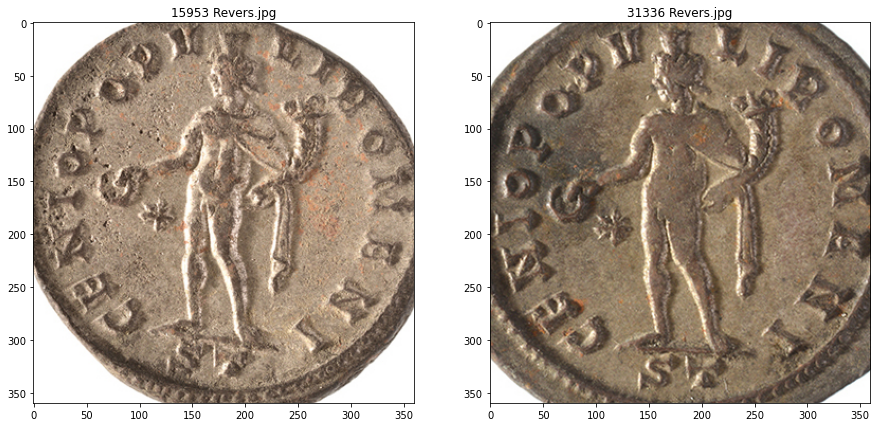

<Figure size 1080x720 with 0 Axes>

############### CLUSTER 2 ############


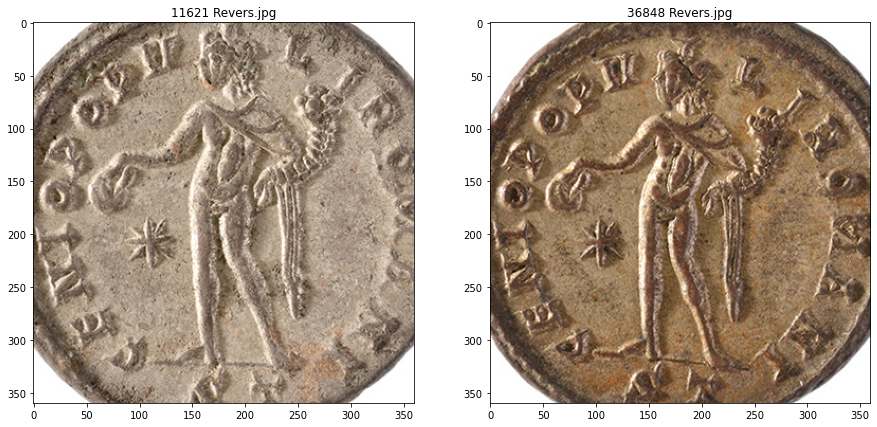

<Figure size 1080x720 with 0 Axes>

############### CLUSTER 3 ############


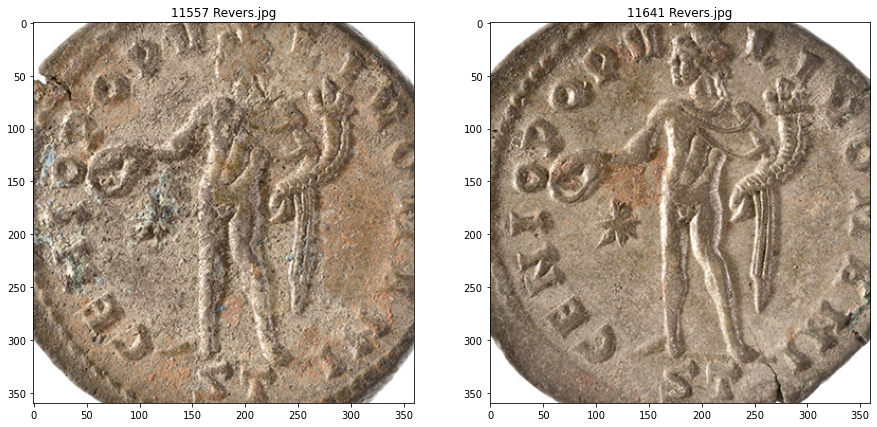

<Figure size 1080x720 with 0 Axes>

In [51]:
i = 0
place = 0
for clst in ClustersMore2:
    plt.show()
    plt.figure()
    place = 0
    print("############### CLUSTER %i ############"%(i+1))
    for idx in clst:
        place = place +1
        plt.subplot(1,2,place)
        img = cropToCoin(os.path.join(dataPath,dataList[idx]))
        plt.imshow(img)
        plt.title("%s"%(dataList[idx]))
        if(place==2):
            place = 0
            plt.show()
            plt.figure()
            
        
    i=i+1

In [61]:
def getNbLiaison(Clusters):
    somme = 0
    for clst in Clusters:
        n,=np.shape(clst)
        somme = somme + int(n*(n-1)/2.0)

    return somme

print(getNbLiaison(ClustersMore2))

7


In [62]:
def getnbClusterSize(Clusters:list,size:int)->int:
    
    s= 0
    for clst in Clusters:
        n, = np.shape(clst)
        if n == size:
            s=s+1
    return s



## Analyse de l'algorithme

Objectif trouver 



In [63]:

nbValues = 500

distList = np.linspace(1,60,nbValues)
nbClusterList = np.zeros(nbValues)
nbliaisons = np.zeros(nbValues)

nbClusterSize2 = np.zeros(nbValues)
nbClusterSize3 = np.zeros(nbValues)
nbClusterSize4 = np.zeros(nbValues)
nbClusterSize5 = np.zeros(nbValues)
nbClusterSize6 = np.zeros(nbValues)
nbClusterSize7 = np.zeros(nbValues)
nbClusterSize8 = np.zeros(nbValues)



for i in range(nbValues):
    dist = distList[i]
    C = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage = "complete" ,distance_threshold=dist).fit_predict(D)
    [nbCluster, Clusters] = getClusterIdx(C,plot=False)
    
    
    
    nbClusterList[i] = nbCluster
    
    nbliaisons[i] = getNbLiaison(Clusters)
    
    nbClusterSize2[i] = getnbClusterSize(Clusters,2)
    nbClusterSize3[i] = getnbClusterSize(Clusters,3)
    nbClusterSize4[i] = getnbClusterSize(Clusters,4)
    nbClusterSize5[i] = getnbClusterSize(Clusters,5)
    nbClusterSize6[i] = getnbClusterSize(Clusters,6)
    nbClusterSize7[i] = getnbClusterSize(Clusters,7)

    
    

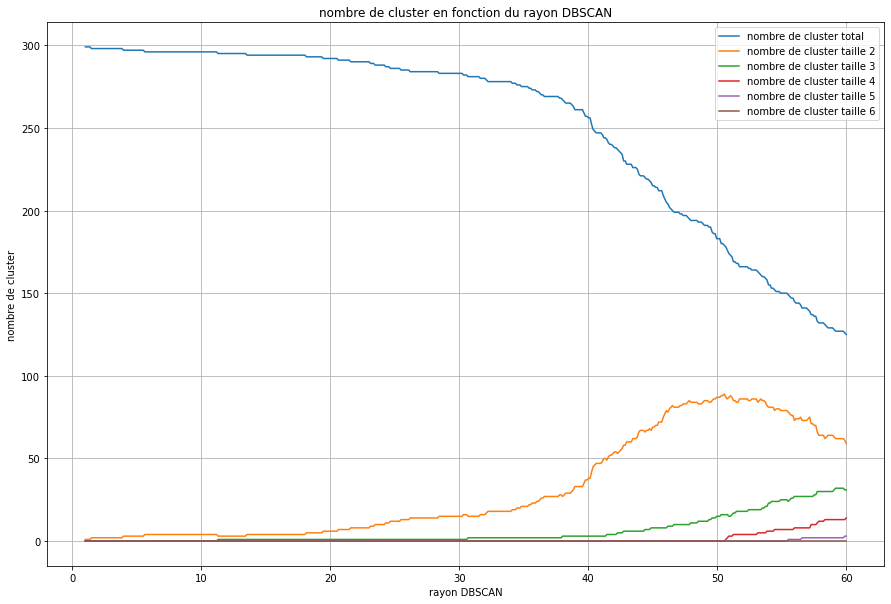

In [64]:
plt.plot(distList,nbClusterList,label="nombre de cluster total")
plt.plot(distList,nbClusterSize2,label="nombre de cluster taille 2")
plt.plot(distList,nbClusterSize3,label="nombre de cluster taille 3")
plt.plot(distList,nbClusterSize4,label="nombre de cluster taille 4")
plt.plot(distList,nbClusterSize5,label="nombre de cluster taille 5")
plt.plot(distList,nbClusterSize6,label="nombre de cluster taille 6")

plt.title("nombre de cluster en fonction du rayon DBSCAN")
plt.xlabel("rayon DBSCAN")
plt.ylabel("nombre de cluster")
plt.grid()
plt.legend()
plt.show()


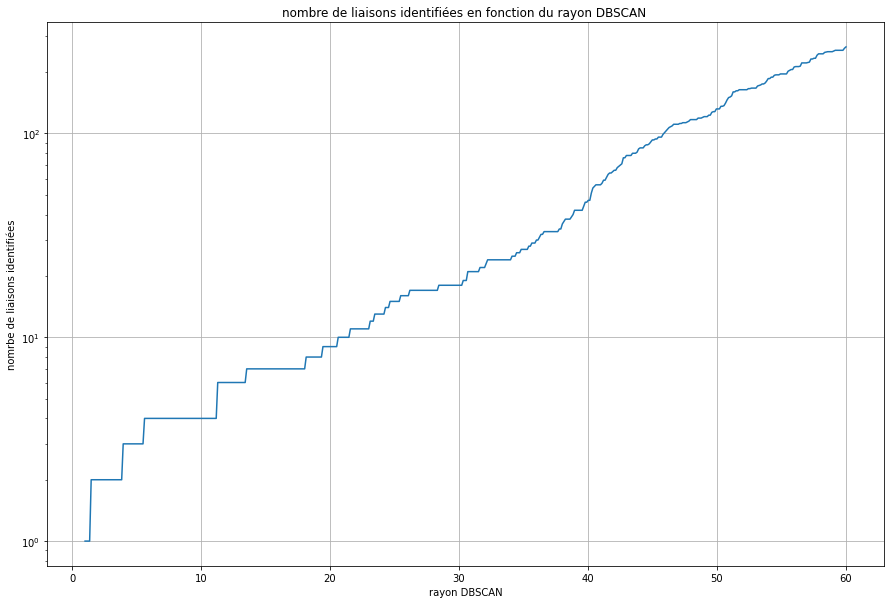

In [65]:
plt.plot(distList,nbliaisons,label="nombre de liaisons")
plt.yscale('log')
plt.title("nombre de liaisons identifiées en fonction du rayon DBSCAN ")
plt.xlabel("rayon DBSCAN")
plt.ylabel("nomrbe de liaisons identifiées")
plt.grid()